# Import from google drive to get the data

In [6]:
# This connects our colab to google Drive so we can pull the data from online
# from google.colab import drive
# drive.mount('/content/drive')

# Install proper packages

In [8]:
!pip install efficientnet_pytorch
!pip install cjm_pandas_utils
!pip install cjm_pil_utils
!pip install cjm_pytorch_utils
!pip install helpers

# Import main packages and modules

In [8]:
# Here we are importing our basic modules
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shutil
import helpers
from efficientnet_pytorch import EfficientNet

Add the below path to system path so that python files stored in the path can be imported

In [10]:
import sys
sys.path.append('/home/iambrink/NOH_Thyroid_Cancer_Data/Runs')

In [5]:
from sklearn import model_selection, metrics

import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from PIL import Image
import re
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor
from torchvision.transforms import v2
from torchvision.io import read_image

/home/iambrink/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [15]:
# Load the data from Drive
noh_fp = '/home/iambrink/NOH_Thyroid_Cancer_Data/TAN'

# Gather data from csv file

In [16]:
noh_data = pd.read_csv('/home/iambrink/NOH_Thyroid_Cancer_Data/data_TAN_v3.csv')
noh_data

,Patient #,FNA biopsy,Surgery diagnosis,Surgery diagnosis in number,fold_0,fold_1,fold_2,fold_3,fold_4,image_path
0,1,Malignant,Anaplastic carcinoma,1.0,train,train,train,train,test,TAN\001\IMG_20220623_134910.jpg
1,1,Malignant,Anaplastic carcinoma,1.0,train,train,train,train,test,TAN\001\IMG_20220623_134915.jpg
2,1,Malignant,Anaplastic carcinoma,1.0,train,train,train,train,test,TAN\001\IMG_20220623_134921.jpg
3,1,Malignant,Anaplastic carcinoma,1.0,train,train,train,train,test,TAN\001\IMG_20220623_135706.jpg
4,1,Malignant,Anaplastic carcinoma,1.0,train,train,train,train,test,TAN\001\IMG_20220623_140029.jpg
...,...,...,...,...,...,...,...,...,...,...
1302,105,Follicular neoplasm,Follicular adenoma,0.0,train,train,train,train,test,TAN\105\IMG_230331130454072.jpg
1303,105,Follicular neoplasm,Follicular adenoma,0.0,train,train,train,train,test,TAN\105\IMG_230331130526195.jpg
1304,105,Follicular neoplasm,Follicular adenoma,0.0,train,train,train,train,test,TAN\105\IMG_230331130543607.jpg
1305,105,Follicular neoplasm,Follicular adenoma,0.0,train,train,train,train,test,TAN\105\IMG_230331130554243.jpg


In [17]:
# This collects the total number of patients by breakdown of cancer or not cancer(1/0)
noh_data['Surgery diagnosis in number'].value_counts().sort_index()

Surgery diagnosis in number
0.0    1086
1.0     143
Name: count, dtype: int64

In [18]:
print(noh_data.columns)

Index(['Patient #', 'FNA biopsy', 'Surgery diagnosis',
       'Surgery diagnosis in number', 'fold_0', 'fold_1', 'fold_2', 'fold_3',
       'fold_4', 'image_path'],
      dtype='object')


In [19]:
# This just strips the data to ensure there is no repeats and showcases a break down of value counts
noh_data[['Patient #', 'Surgery diagnosis in number']].drop_duplicates()['Surgery diagnosis in number'].value_counts().sort_index()

Surgery diagnosis in number
0.0    90
1.0    10
Name: count, dtype: int64

# Plotting a graph of number of patients
Break down of cancer and non-cancer

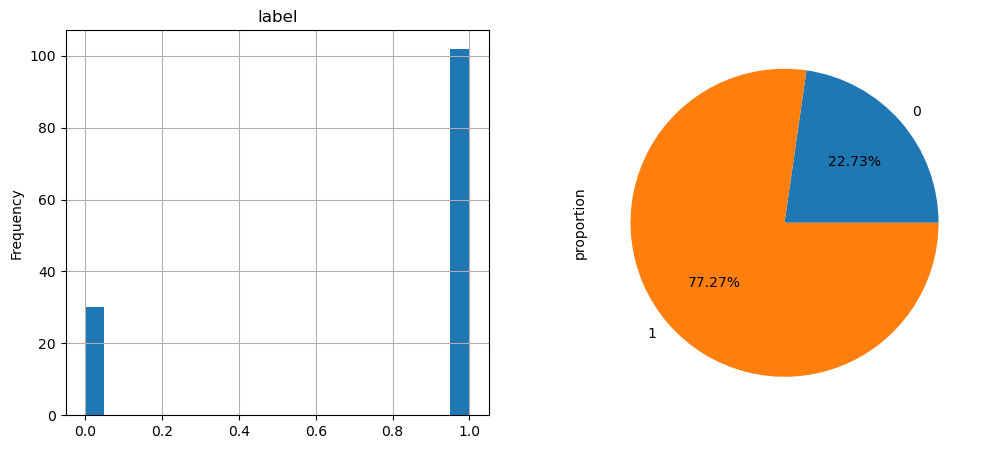

In [18]:
# Drop the duplicates
noh_sum = noh_data[['Patient #', 'Surgery diagnosis in number']].drop_duplicates()
# Define sizes for the graph
fig, axs = plt.subplots(1,2,figsize=(12,5))
# Create the graphs and plot them
noh_sum['Surgery diagnosis in number'].plot(kind='hist', bins=20, title='label',ax=axs[0], grid=True)
noh_sum['Surgery diagnosis in number'].value_counts(dropna=False, normalize=True).fillna('NA').sort_index().plot(kind='pie', autopct='%.2f%%', ax=axs[1])
plt.gca().spines[['top', 'right',]].set_visible(False)

# Get fold Breakdown to know what youre working with 

In [19]:
import pandas as pd

# Define all the folds you're interested in
folds = ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4', 'test_split']

# Define labels for the rows
labels = [
    'Total Number of Images', 'Total Number of Patients',
    'Total Number of Cancer Patients', 'Number of Training Cancer Patients',
    'Number of Testing Cancer Patients', 'Total Number of Non-Cancer Patients',
    'Number of Training Non-Cancer Patients', 'Number of Testing Non-Cancer Patients',
    'Total Number of Cancer Images', 'Number of Training Cancer Images',
    'Number of Testing Cancer Images', 'Total Number of Non-Cancer Images',
    'Number of Training Non-Cancer Images', 'Number of Testing Non-Cancer Images'
]

# Initialize the data dictionary with labels
data = {'Labels': labels}

# Iterate over each fold and calculate the statistics for each
for foldk in folds:
    # Filter the data for the selected fold (train or test data)
    fold_data = noh_data[noh_data[foldk].isin(['train', 'test'])]  # Pulls both 'train' and 'test' data
    
    # Calculating statistics
    total_patients = len(fold_data['Patient #'].unique())  # Count unique patients (both cancer and non-cancer)
    total_images = len(fold_data['image_path'].unique())  # Count unique images
    
    # Number of cancer and non-cancer patients
    total_cancer_patients = len(fold_data[fold_data['Surgery diagnosis in number'] == 1]['Patient #'].unique())
    total_non_cancer_patients = total_patients - total_cancer_patients
    
    # Split into training and testing sets
    train_data = fold_data[fold_data[foldk] == 'train']
    test_data = fold_data[fold_data[foldk] == 'test']
    
    # Cancer and non-cancer patients in training and testing sets
    train_cancer_patients = len(train_data[train_data['Surgery diagnosis in number'] == 1]['Patient #'].unique())
    test_cancer_patients = len(test_data[test_data['Surgery diagnosis in number'] == 1]['Patient #'].unique())
    
    train_non_cancer_patients = len(train_data[train_data['Surgery diagnosis in number'] != 1]['Patient #'].unique())
    test_non_cancer_patients = len(test_data[test_data['Surgery diagnosis in number'] != 1]['Patient #'].unique())
    
    # Number of cancer and non-cancer images
    total_cancer_images = len(fold_data[fold_data['Surgery diagnosis in number'] == 1]['image_path'].unique())
    total_non_cancer_images = total_images - total_cancer_images
    
    train_cancer_images = len(train_data[train_data['Surgery diagnosis in number'] == 1]['image_path'].unique())
    test_cancer_images = len(test_data[test_data['Surgery diagnosis in number'] == 1]['image_path'].unique())
    
    train_non_cancer_images = len(train_data[train_data['Surgery diagnosis in number'] != 1]['image_path'].unique())
    test_non_cancer_images = len(test_data[test_data['Surgery diagnosis in number'] != 1]['image_path'].unique())
    
    # Calculating percentages
    cancer_patient_percentage = (total_cancer_patients / total_patients) * 100
    non_cancer_patient_percentage = (total_non_cancer_patients / total_patients) * 100
    train_cancer_patient_percentage = (train_cancer_patients / total_patients) * 100
    test_cancer_patient_percentage = (test_cancer_patients / total_patients) * 100
    train_non_cancer_patient_percentage = (train_non_cancer_patients / total_patients) * 100
    test_non_cancer_patient_percentage = (test_non_cancer_patients / total_patients) * 100
    
    # Add the calculated values to the data dictionary for this fold
    data[foldk] = [
        total_images, total_patients,
        total_cancer_patients, train_cancer_patients,
        test_cancer_patients, total_non_cancer_patients,
        train_non_cancer_patients, test_non_cancer_patients,
        total_cancer_images, train_cancer_images,
        test_cancer_images, total_non_cancer_images,
        train_non_cancer_images, test_non_cancer_images
    ]
    
    # Add percentages to the data dictionary for this fold
    data[f'{foldk} Percentage'] = [
        None, None,
        f'{cancer_patient_percentage:.2f}%', f'{train_cancer_patient_percentage:.2f}%',
        f'{test_cancer_patient_percentage:.2f}%', f'{non_cancer_patient_percentage:.2f}%',
        f'{train_non_cancer_patient_percentage:.2f}%', f'{test_non_cancer_patient_percentage:.2f}%',
        f'{(total_cancer_images / total_images) * 100:.2f}%', f'{(train_cancer_images / total_images) * 100:.2f}%',
        f'{(test_cancer_images / total_images) * 100:.2f}%', f'{(total_non_cancer_images / total_images) * 100:.2f}%',
        f'{(train_non_cancer_images / total_images) * 100:.2f}%', f'{(test_non_cancer_images / total_images) * 100:.2f}%'
    ]

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame as a table in Jupyter
df


,Labels,fold_0,fold_0 Percentage,fold_1,fold_1 Percentage,fold_2,fold_2 Percentage,fold_3,fold_3 Percentage,fold_4,fold_4 Percentage,test_split,test_split Percentage
0,Total Number of Images,2017,None,2017,None,2017,None,2017,None,2017,None,2017,None
1,Total Number of Patients,132,None,132,None,132,None,132,None,132,None,132,None
2,Total Number of Cancer Patients,102,77.27%,102,77.27%,102,77.27%,102,77.27%,102,77.27%,102,77.27%
3,Number of Training Cancer Patients,87,65.91%,87,65.91%,86,65.15%,86,65.15%,87,65.91%,77,58.33%
4,Number of Testing Cancer Patients,15,11.36%,15,11.36%,16,12.12%,16,12.12%,15,11.36%,25,18.94%
5,Total Number of Non-Cancer Patients,30,22.73%,30,22.73%,30,22.73%,30,22.73%,30,22.73%,30,22.73%
6,Number of Training Non-Cancer Patients,25,18.94%,25,18.94%,26,19.70%,26,19.70%,26,19.70%,22,16.67%
7,Number of Testing Non-Cancer Patients,5,3.79%,5,3.79%,4,3.03%,4,3.03%,4,3.03%,8,6.06%
8,Total Number of Cancer Images,1565,77.59%,1565,77.59%,1565,77.59%,1565,77.59%,1565,77.59%,1565,77.59%
9,Number of Training Cancer Images,1337,66.29%,1325,65.69%,1319,65.39%,1310,64.95%,1327,65.79%,1207,59.84%


# Gather per patient breakdown
Develop foldk to get a test train split

In [12]:
foldk = 'fold_2'
noh_data.groupby([foldk,'Surgery diagnosis in number'])['Patient #'].nunique().to_frame().reset_index().pivot_table(index=foldk, columns='Surgery diagnosis in number', values='Patient #').astype(int)

Surgery diagnosis in number,0,1
fold_2,,
test,6,20
train,24,82


# Set up per image analysis
Define the image path with number of images and classification total

In [1]:
# This prints the total instances of 0 and 1 for all the images including the patients based on the test train split
noh_data.groupby([foldk,'Surgery diagnosis in number'])['image_path'].nunique().to_frame().reset_index().pivot_table(index=foldk, columns='Surgery diagnosis in number', values='image_path').astype(int)

NameError: name 'noh_data' is not defined

In [13]:
# Connect each image link to a test and train split
noh_data['image_path'] = noh_data.apply(lambda row: row.image_path.replace('../data','/home/iambrink/NOH_Thyroid_Cancer_Data/RUNS'), axis = 1)

In [14]:
# Show the plot of the image address, the label of the image, and if it is testing or training data
img_ds = noh_data[['image_path', 'Surgery diagnosis in number', foldk]]
img_ds

,image_path,Surgery diagnosis in number,fold_2
0,NOH\001\IMG_20221219_101351.jpg,1,train
1,NOH\001\IMG_20221219_101514.jpg,1,train
2,NOH\001\IMG_20221219_101528.jpg,1,train
3,NOH\001\IMG_20221219_101532.jpg,1,train
4,NOH\001\IMG_20221219_101540.jpg,1,train
...,...,...,...
2012,NOH\132\IMG_20230228_134633.jpg,1,test
2013,NOH\132\IMG_20230228_134655.jpg,1,test
2014,NOH\132\IMG_20230228_134749.jpg,1,test
2015,NOH\132\IMG_20230228_134752.jpg,1,test


## Develop and prepare data

In [24]:
# Crop the image to be saved
plt.rcParams["savefig.bbox"] = 'tight'

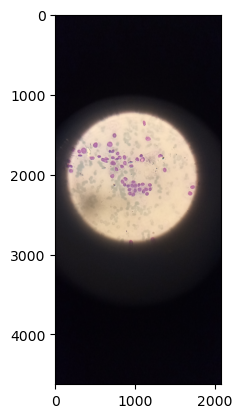

In [25]:
# Replace the backslashes in the CSV path and prepend the base path
base_path = "/home/iambrink/NOH_Thyroid_Cancer_Data/"
relative_path = img_ds.iloc[0]['image_path'].replace("\\", "/")
img_path = os.path.join(base_path, relative_path)

# Open and display the image
img = Image.open(img_path)
plt.imshow(img)


# Define testing and training transformers

Standard image size is 244px

In [26]:
# Change the image size in the transforms
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(320, antialias=True),  # Change to model size here
    v2.RandomCrop(320),              # Change crop to match new size
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(320, antialias=True),  # Change to model size here
    v2.CenterCrop(size=320),         # Change crop to match new size
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


## Batch size

In [27]:
# Define a batch size for the AI model
'''Could attempt increasing batch size on my PC'''
batch_size=32

# Dataset and dataloader

In [28]:
import torch
from PIL import Image
import os

class NOHThyroidDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, base_path, transform=None):
        self.dataframe = dataframe
        self.base_path = base_path  # Define the base path in the constructor
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the relative image path from the dataframe and append it to the base path
        image_path = os.path.join(self.base_path, self.dataframe['image_path'][idx].replace("\\", "/"))
        label = self.dataframe['Surgery diagnosis in number'][idx]

        # Open the image
        image = Image.open(image_path)

        # Apply any transformation (if available)
        if self.transform:
            image = self.transform(image)

        return image, label


In [29]:
# This is used for data spliting
train_df = img_ds[img_ds[foldk]=='train'].reset_index(drop=True)
test_df = img_ds[img_ds[foldk]=='test'].reset_index(drop=True)

# Define test and train loaders

In [30]:
# Define the base path to the folder containing the images on Google Drive
base_path = "/home/iambrink/NOH_Thyroid_Cancer_Data/"

# Create the dataset, passing the base path to it
train_dataset = NOHThyroidDataset(dataframe=train_df, base_path=base_path, transform=train_transform)

# Create the DataLoader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [31]:
# Define the base path to the folder containing the images on Google Drive
base_path = "/home/iambrink/NOH_Thyroid_Cancer_Data/"

# Create the dataset, passing the base path to it
test_dataset = NOHThyroidDataset(dataframe=test_df, base_path=base_path, transform=test_transform)

# Create the DataLoader
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

##  Inspect Image

In [32]:
# Set the standard stats
norm_stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

Full image path: /home/iambrink/NOH_Thyroid_Cancer_Data/NOH/037/IMG_20230116_115246.jpg


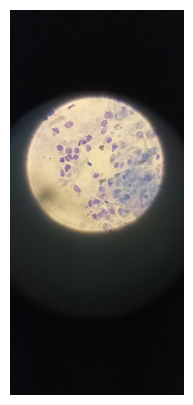

In [33]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the base path to your images on Google Drive
base_path = "/home/iambrink/NOH_Thyroid_Cancer_Data/"

# Randomly select an image path and append it to the base path
item_path = np.random.choice(train_df['image_path'])
full_item_path = os.path.join(base_path, item_path.replace("\\", "/"))  # Replace backslashes

# Print the full path for verification
print(f"Full image path: {full_item_path}")

# Open and display the image
sample_img = Image.open(full_item_path)
fig = plt.figure(figsize=(10, 5))
plt.imshow(sample_img)
plt.axis('off')  # Hide the axis
plt.show()


Feature batch shape: torch.Size([32, 3, 320, 320])
Labels batch shape: torch.Size([32])


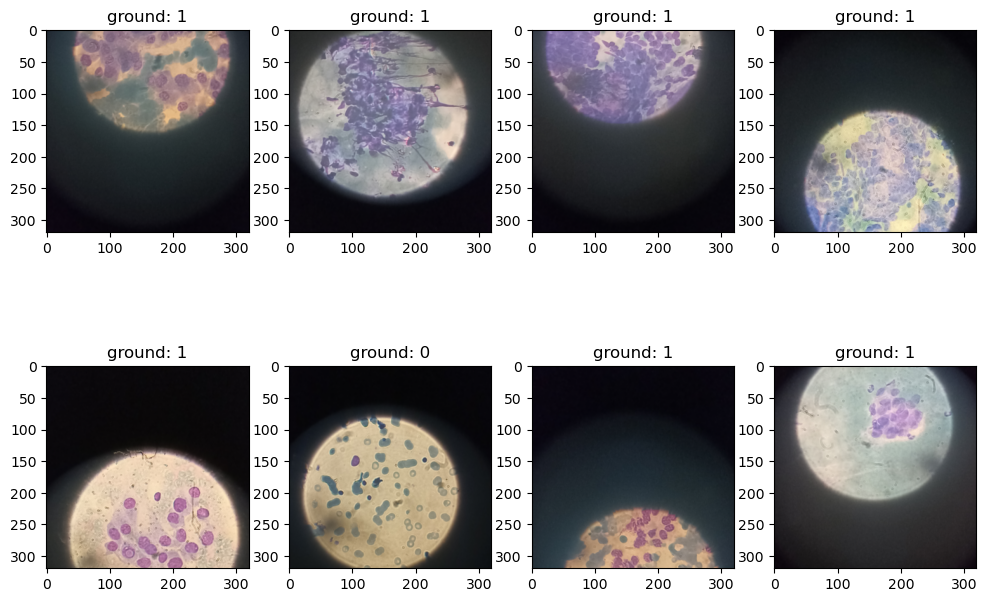

In [34]:
# Now use the DataLoader to get a batch of data
train_features, train_labels = next(iter(trainloader))

# Display sample images from the batch
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

indx = 0
f, axarr = plt.subplots(2, 4, figsize=(12, 8))
for r in range(0, 2):
    for c in range(0, 4):
        img = train_features[indx].squeeze()
        label = train_labels[indx]

        # Convert tensor to PIL image after denormalizing
        axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img, *norm_stats)))
        axarr[r, c].set_title(f'ground: {label}')
        indx += 1

plt.show()


## GPU detection

In [35]:
# Display the GPU's
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")
    # List information about each GPU
    for i in range(num_gpus):
        gpu_info = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {gpu_info.name}")
        print(f"   Compute Capability: {gpu_info.major}.{gpu_info.minor}")
        print(f"   Total Memory: {gpu_info.total_memory / (1024 ** 3):.2f} GB\n")
else:
    print("No GPUs available.")


Number of available GPUs: 1
GPU 0: NVIDIA GeForce RTX 4070
   Compute Capability: 8.9
   Total Memory: 11.99 GB



In [36]:
# If there is a device, take the first else use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Save model with tensorboard

In [37]:
# Define where to save the model
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("/home/iambrink/NOH_Thyroid_Cancer_Data/Trial")

2024-10-22 21:55:28.574809: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 21:55:28.729932: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load weights for model

In [38]:
# Load the pretrained weights onto the model
model = EfficientNet.from_pretrained('efficientnet-b0',num_classes=2)

Loaded pretrained weights for efficientnet-b0


# Print model information before training

In [39]:
# Get the number of classes (in this case it is 0 and 1 for 2 classes)
train_df['Surgery diagnosis in number'].nunique()

2

In [40]:
# Define the number of in and out features
model._fc = nn.Linear(model._fc.in_features, train_df['Surgery diagnosis in number'].nunique())
model.to(device);

In [41]:
model._fc

Linear(in_features=1280, out_features=2, bias=True)

# Define epochs

In [42]:
# Set the number of epochs and the best accuracy
num_epochs = 100
best_val_acc = 0.0

# Define criterion, optimizer, and scheduler

This one here is the origional

In [42]:
# '''This is where we can make alot of changes to test and see what works better'''
# # This is to define our standard loss function
# criterion = nn.CrossEntropyLoss()
# # Set up our learning rate with Adam
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# # Define some of our other factors, such as stoppage, patience, and verbose for the model
# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)

In [43]:
'''This is where we can make alot of changes to test and see what works better'''
# This is to define our standard loss function
criterion = nn.CrossEntropyLoss()
# Set up our learning rate with Adam
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
# Define some of our other factors, such as stoppage, patience, and verbose for the model
# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 500)  

This is the one to try and edit things

In [45]:
# '''This is where we can make alot of changes to test and see what works better'''
# # This is to define our standard loss function
# criterion = nn.CrossEntropyLoss()
# # Set up our learning rate with Adam
# # optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
# import torch.optim as optim

# optimizer = optim.Adam(
#     model.parameters(),
#     lr=1e-4,                 # Learning rate
#     betas=(.8, 0.999),      # Coefficients for computing running averages
#     weight_decay=1e-4,       # L2 regularization
# )


# # Define some of our other factors, such as stoppage, patience, and verbose for the model
# # scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 500)

# Preformance evaluation

In [46]:
# This functions is used to evaluate and display the proformance of our classification model
def report_clf(preds_ts, outs_ts):
    np_preds = [i.numpy() for i in preds_ts]
    np_outs = [i.numpy() for i in outs_ts]

    np_preds = np.array([i for s in np_preds for i in s])
    np_outs = np.array([i for s in np_outs for i in s])
    assert np_preds.shape == np_outs.shape

    print(metrics.classification_report(np_outs, np_preds))

    cm = metrics.confusion_matrix(np_outs, np_preds)
    d = metrics.ConfusionMatrixDisplay(cm)
    d.plot()
    plt.show()

In [47]:
# This is used to evaluate the model when ran on a dataset
def evaluate_dataset(model, ds_loader):
    model.eval()
    loss = 0.0
    acc = 0.0
    preds = []
    outs = []
    for _, (data, target) in enumerate(tqdm(ds_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss += loss.item()
        acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
        preds.append(output.cpu().argmax(dim=1))
        outs.append(target.cpu())

    loss /= len(testloader)
    acc /= len(testloader)
    print('Test Loss: {:.4f} \tTest Acc: {:.4f}'.format(loss, acc))
    report_clf(preds, outs)
    return acc,preds, outs

# If model pre-exists, compare old model to new model

In [48]:
# Show the evaluation of the prexisting mdoel
def run_predict_testset():
    test_features, test_labels = next(iter(testloader))
    # Make a prediction with the model
    class_names = [0,1,2]
    with torch.no_grad():
        preds = model(test_features.to(device))
        print(f"Feature batch shape: {test_features.size()}")
        print(f"Labels batch shape: {test_labels.size()}")
        indx = 0
        f, axarr = plt.subplots(3, 3, figsize=(12, 8))
        for r in range(0, 3):
            for c in range(0, 3):
                img_tensor = test_features[indx]
                label = class_names[test_labels[indx].numpy()]
                print('Label: ', label)
                # Scale the model predictions to add up to 1
                pred_scores = torch.softmax(preds[indx], dim=0)
                # Get the highest confidence score
                confidence_score = pred_scores.max()
                # Get the class index with the highest confidence score and convert it to the class name
                pred_class = class_names[torch.argmax(pred_scores)]
                print('Predicted: ', pred_class)
                axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img_tensor, *norm_stats)))
                axarr[r, c].set_title(f"ground: {label}, pred: {pred_class}, conf: {confidence_score*100:.2f}%")
                indx+=1
        plt.tight_layout()
        plt.show()

Define basepath for the old model

In [49]:
# Pre-existing model
baseline_model_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/Test_Trial.pth'

In [50]:
# Reload model to run
model_fp = Path(baseline_model_path)
if model_fp.exists():
    model.load_state_dict(torch.load(str(model_fp), map_location=torch.device(device)))
    best_val_acc, _, _ = evaluate_dataset(model, testloader)
    run_predict_testset()

In [51]:
# Print the best accuracy
best_val_acc

0.0

# Define our seed for the model

In [52]:
import torch
import numpy as np
import random

def set_seed(seed_value=42):
    # Set seed for Python's random module
    random.seed(seed_value)

    # Set seed for NumPy's random number generator
    np.random.seed(seed_value)

    # Set seed for PyTorch (both CPU and GPU, if applicable)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


# Define early stopping based on AUC

In [53]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_auc = -float('inf')  # Track the best AUC, start with a very low number

    def __call__(self, val_auc, model):
        if self.best_score is None:
            self.best_score = val_auc
            self.save_checkpoint(val_auc, model)
        elif val_auc < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_auc
            self.save_checkpoint(val_auc, model)
            self.counter = 0

    def save_checkpoint(self, val_auc, model):
        '''Saves model when AUC improves.'''
        if self.verbose:
            print(f'AUC improved ({self.best_auc:.6f} --> {val_auc:.6f}). Saving model...')
        self.best_auc = val_auc
        # Save model checkpoint if needed:
        # torch.save(model.state_dict(), 'checkpoint.pth')


# Train model

In [54]:
# # @title Default title text
# # Run a new model to see how well it does
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     train_acc = 0.0
#     for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
#         train_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
#     train_loss /= len(trainloader)
#     train_acc /= len(trainloader)

#     model.eval()
#     val_loss = 0.0
#     val_acc = 0.0
#     for batch_idx, (data, target) in enumerate(tqdm(testloader)):
#         data, target = data.to(device), target.to(device)
#         output = model(data)
#         loss = criterion(output, target)
#         val_loss += loss.item()
#         val_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
#     val_loss /= len(testloader)
#     val_acc /= len(testloader)

#     scheduler.step(val_loss)

#     print('Epoch: {} \tTrain Loss: {:.4f} \tTrain Acc: {:.4f} \tVal Loss: {:.4f} \tVal Acc: {:.4f}'.format(
#         epoch, train_loss, train_acc, val_loss, val_acc))
#     writer.add_scalar('Train/Loss', loss.item(), epoch * len(trainloader) + batch_idx)
#     writer.add_scalar('Train/Accuracy', train_acc, epoch * len(trainloader) + batch_idx)
#     writer.add_scalar('Validation/Loss', val_loss, epoch * len(testloader) + batch_idx)
#     writer.add_scalar('Validation/Accuracy', val_acc, epoch * len(testloader) + batch_idx)

#     print(val_acc, best_val_acc)
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         evaluate_dataset(model, testloader)
#         print(f'Better result, val: {best_val_acc}')
#         torch.save(model.state_dict(), baseline_model_path)

# Adjust for AUC precentage and implement early stoppage

In [60]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import torch.nn.functional as F  # for softmax
from tqdm import tqdm  # for progress bar
import numpy as np

# Initialize variables for storing true and predicted values for the test set
y_true = []
y_pred = []
y_prob = []  # for storing probabilities for AUC calculation

best_val_acc = 0.0
best_auc = 0.0

# Early stopping setup
early_stopping = EarlyStopping(patience=3, verbose=True)

# Epoch loop
for epoch in range(num_epochs):
    # Training loop (unchanged)
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    train_loss /= len(trainloader)
    train_acc /= len(trainloader)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    y_true.clear()
    y_pred.clear()
    y_prob.clear()  # Clear previous probabilities

    for batch_idx, (data, target) in enumerate(tqdm(testloader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()
        predictions = output.cpu().argmax(dim=1)
        val_acc += accuracy_score(predictions, target.cpu())
        
        # Store true and predicted labels
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predictions.numpy())
        
        # Store probabilities for AUC (apply softmax)
        probabilities = F.softmax(output, dim=1).detach().cpu().numpy()
        y_prob.extend(probabilities)

    val_loss /= len(testloader)
    val_acc /= len(testloader)

    # Calculate AUC
    y_prob_positive_class = [prob[1] for prob in y_prob]  # Extract probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(y_true, y_prob_positive_class)
    calculated_auc = auc(fpr, tpr)

    scheduler.step(val_loss)

    # Print metrics for the epoch
    print('Epoch: {} \tTrain Loss: {:.4f} \tTrain Acc: {:.4f} \tVal Loss: {:.4f} \tVal Acc: {:.4f} \tAUC: {:.4f}'.format(
        epoch, train_loss, train_acc, val_loss, val_acc, calculated_auc))
    
    writer.add_scalar('Train/Loss', loss.item(), epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Train/Accuracy', train_acc, epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Validation/Loss', val_loss, epoch * len(testloader) + batch_idx)
    writer.add_scalar('Validation/Accuracy', val_acc, epoch * len(testloader) + batch_idx)

    # Update best AUC if applicable
    if calculated_auc > best_auc:
        best_auc = calculated_auc
        evaluate_dataset(model, testloader)
        print(f'New best AUC: {best_auc:.4f}')
        torch.save(model.state_dict(), baseline_model_path)

    # Check for early stopping based on AUC
    early_stopping(calculated_auc, model)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training...")
        break


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


AttributeError: 'BCEWithLogitsLoss' object has no attribute 'step'

# Decreased Threshhold for False Negativies

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
# import torch.nn.functional as F  # for softmax
# from tqdm import tqdm  # for progress bar
# import numpy as np

# # Initialize variables for storing true and predicted values for the test set
# y_true = []
# y_pred = []
# y_prob = []  # for storing probabilities for AUC calculation

# best_val_acc = 0.0
# best_auc = 0.0

# # Define the threshold for classifying as positive (e.g., 0.3)
# threshold = 0.3

# # Early stopping setup
# early_stopping = EarlyStopping(patience=10, verbose=True)

# # Epoch loop
# for epoch in range(num_epochs):
#     # Training loop (unchanged)
#     model.train()
#     train_loss = 0.0
#     train_acc = 0.0
#     for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
#         train_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
#     train_loss /= len(trainloader)
#     train_acc /= len(trainloader)

#     model.eval()
#     val_loss = 0.0
#     val_acc = 0.0
#     y_true.clear()
#     y_pred.clear()
#     y_prob.clear()  # Clear previous probabilities

#     for batch_idx, (data, target) in enumerate(tqdm(testloader)):
#         data, target = data.to(device), target.to(device)
#         output = model(data)
#         loss = criterion(output, target)
#         val_loss += loss.item()
        
#         # Apply softmax to get probabilities
#         probabilities = F.softmax(output, dim=1).detach().cpu().numpy()

#         # Store true labels
#         y_true.extend(target.cpu().numpy())

#         # Extract probabilities for the positive class (cancer class)
#         y_prob_positive_class = probabilities[:, 1]

#         # Predict positive class based on the custom threshold (e.g., 0.3)
#         y_pred_thresholded = (y_prob_positive_class >= threshold).astype(int)

#         # Store predictions and update accuracy
#         y_pred.extend(y_pred_thresholded)
#         val_acc += accuracy_score(y_pred_thresholded, target.cpu())

#         # Store probabilities for AUC calculation
#         y_prob.extend(y_prob_positive_class)

#     val_loss /= len(testloader)
#     val_acc /= len(testloader)

#     # Calculate AUC
#     fpr, tpr, _ = roc_curve(y_true, y_prob)
#     calculated_auc = auc(fpr, tpr)

#     #when running CosineAnnealingLR we need to have a step returning no parameters or else we will get a warning
#     scheduler.step()
#     #If we are running LReduceLROnPlateau then we will run this
#     #scheduler.step(val_loss)
    

#     # Print metrics for the epoch
#     print('Epoch: {} \tTrain Loss: {:.4f} \tTrain Acc: {:.4f} \tVal Loss: {:.4f} \tVal Acc: {:.4f} \tAUC: {:.4f}'.format(
#         epoch, train_loss, train_acc, val_loss, val_acc, calculated_auc))
    
#     writer.add_scalar('Train/Loss', loss.item(), epoch * len(trainloader) + batch_idx)
#     writer.add_scalar('Train/Accuracy', train_acc, epoch * len(trainloader) + batch_idx)
#     writer.add_scalar('Validation/Loss', val_loss, epoch * len(testloader) + batch_idx)
#     writer.add_scalar('Validation/Accuracy', val_acc, epoch * len(testloader) + batch_idx)

#     # Update best AUC if applicable
#     if calculated_auc > best_auc:
#         best_auc = calculated_auc
#         evaluate_dataset(model, testloader)
#         print(f'New best AUC: {best_auc:.4f}')
#         torch.save(model.state_dict(), baseline_model_path)

#     # Check for early stopping based on AUC
#     early_stopping(calculated_auc, model)
#     if early_stopping.early_stop:
#         print("Early stopping triggered. Stopping training...")
#         break



# Evaluate results

In [53]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score

# ... (your model training and validation code)

# After getting your predictions and probabilities
# Calculate AUC
calculated_auc = roc_auc_score(y_true, y_prob)

# Calculate Precision, Recall, and F1 Score
report = classification_report(y_true, y_pred, output_dict=True)
precision = report['1']['precision']  # Assuming the positive class is '1'
recall = report['1']['recall']
f1_score = report['1']['f1-score']

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)  # Calculate accuracy here

# Print the classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Print the desired metrics
print(f'AUC: {calculated_auc:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1_score:.4f}')
print(f'Accuracy: {accuracy:.4f}')  # Now accuracy is defined

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.35      0.51        82
           1       0.86      0.99      0.92       315

    accuracy                           0.86       397
   macro avg       0.90      0.67      0.72       397
weighted avg       0.87      0.86      0.84       397

AUC: 0.8546
Recall: 0.9937
Precision: 0.8552
F1 Score: 0.9192
Accuracy: 0.8615
Confusion Matrix:
[[ 29  53]
 [  2 313]]


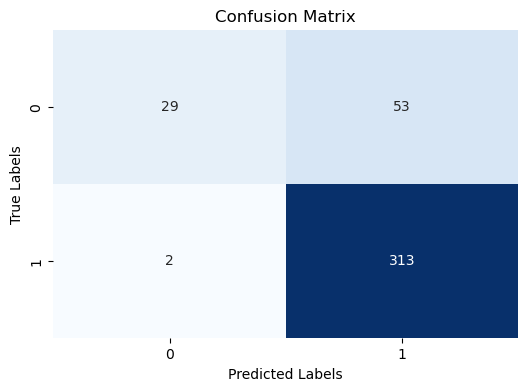

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()


In [ ]:
# Reinitialize your model
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1)

# Load the state dict into the model
model.load_state_dict(torch.load(f"/home/iambrink/NOH_Thyroid_Cancer_Data/Best_model_trial_5_with_AUC_0.9740.pth"))

# Set the model to evaluation mode
model.eval()

Evaluating: 100%|██████████| 15/15 [00:37<00:00,  2.53s/batch]

Threshold (0.2) - AUC: 0.9975, Accuracy: 0.9832, F1: 0.9888, Precision: 0.9944, Recall: 0.9832

Confusion Matrix:
[[115   2]
 [  6 352]]


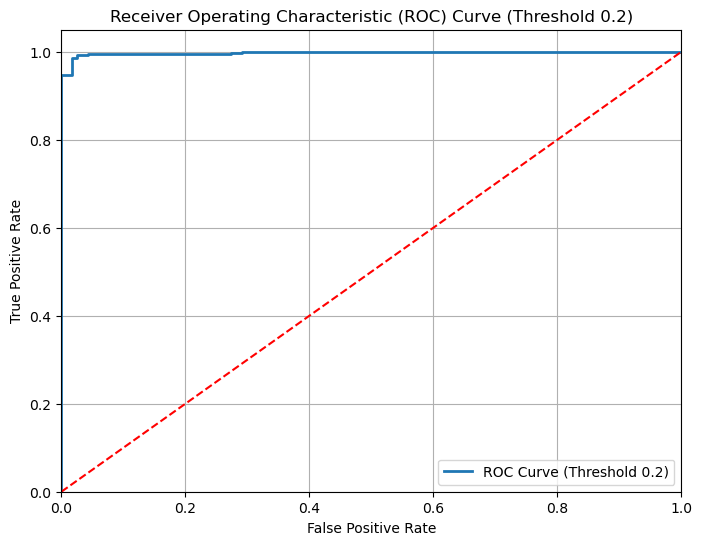

Threshold (0.5) - AUC: 0.9975, Accuracy: 0.9789, F1: 0.9859, Precision: 0.9943, Recall: 0.9777

Confusion Matrix:
[[115   2]
 [  8 350]]


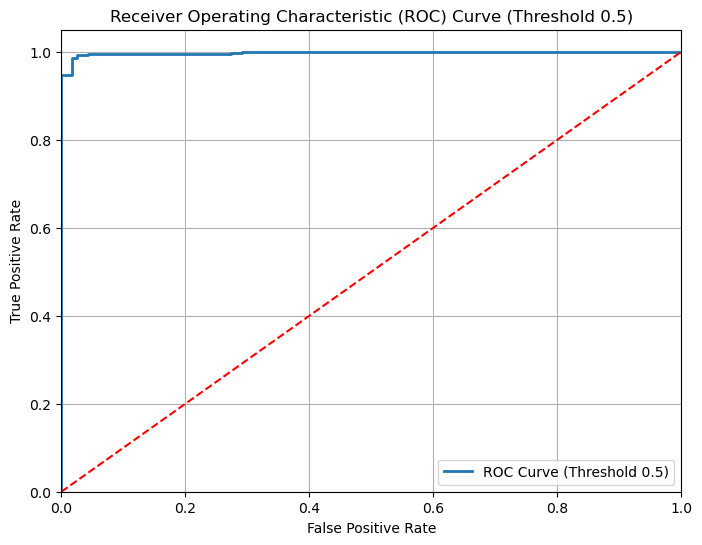

Threshold (0.8) - AUC: 0.9975, Accuracy: 0.9747, F1: 0.9831, Precision: 0.9943, Recall: 0.9721

Confusion Matrix:
[[115   2]
 [ 10 348]]


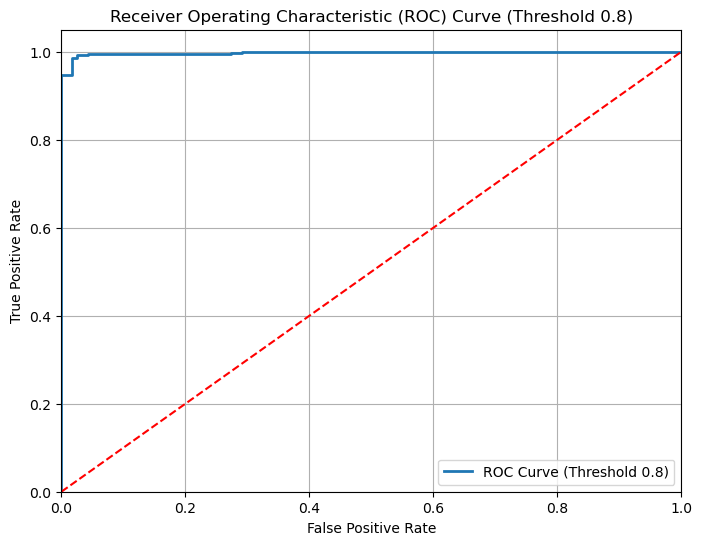

In [46]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load your CSV file
data_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/NOV_Kfold_Data.csv'  # Adjust the path to your CSV file
dataframe = pd.read_csv(data_path)

# Step 1: Filter the test data
test_df = dataframe[dataframe['test_split'] == 'test'].reset_index(drop=True)

# Step 2: Create a test dataset and dataloader
test_dataset = NOHThyroidDataset(dataframe=test_df, base_path=base_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 3: Evaluate the model
model.eval()  # Ensure the model is in evaluation mode
y_true = []
y_pred_proba = []

with torch.no_grad():  # Disable gradient calculation
    for images, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
        # Filter out images with placeholder labels (if any)
        valid_indices = labels != -1  # Adjust based on your placeholder label handling
        if valid_indices.sum() == 0:
            continue  # Skip this batch if all labels are invalid

        valid_images = images[valid_indices]
        valid_labels = labels[valid_indices]

        outputs = model(valid_images)

        # Collect true labels and predicted probabilities
        y_true.extend(valid_labels.cpu().numpy())
        y_pred_proba.extend(outputs.cpu().numpy())

# Convert y_true and y_pred_proba to NumPy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

# List of thresholds to evaluate
thresholds = [0.2, 0.5, 0.8]  # Adjust this list based on your needs

for threshold in thresholds:
    # Make predictions based on the current threshold
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate metrics for the current threshold
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)

    # Print out metrics
    print(f"Threshold ({threshold}) - AUC: {auc:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # Confusion matrix for the current threshold
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (Threshold {threshold})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve (Threshold {threshold})')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
